<a href="https://colab.research.google.com/github/CaritoRamos/Predictive-and-Exploratory-Analysis-of-UNMSM-Exams/blob/main/An%C3%A1lisis_Predictivo_Admision_UNMSM_(EBR_y_EBA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREDICCION DE LA PROBABILIDAD DE INGRESO A LA UNMSM, MODALIDAD (EBR y EBA)**

# **1. DATA WRANGLING**

In [ ]:
#Librerías
!pip install plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import files
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind


#Para el Modelo:
!pip install scikit-learn xgboost lightgbm catboost
import joblib #Para guardar el modelo entrenado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/CaritoRamos/Predictive-and-Exploratory-Analysis-of-UNMSM-Exams/refs/heads/main/resultados_historico.csv')
df.head()

,CODIGO,APELLIDOS Y NOMBRES,CARRERA,PUNTAJE,PUESTO,ESTATUS,MODALIDAD,SEDE,AÑO
0,877220,"ABAD CONCHA, MIKHAIL MARED MARZUK",MEDICINA HUMANA,1098.125,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025
1,861521,"ABAD CONDORI, DANITZA ROCIO",MEDICINA HUMANA,1127.875,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025
2,866556,"ABAD GOMEZ, EVELYN DAYANNA",MEDICINA HUMANA,818.875,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025
3,867339,"ABAN CASTILLO, THALIA XIMENA",MEDICINA HUMANA,504.250,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025
4,876347,"ABANTO BENITES, SAMANTHA SOFIA",MEDICINA HUMANA,775.875,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025


In [ ]:
#Tamaño del Dataset (Filas y columnas)
df.shape

(145212, 9)

In [ ]:
#Tipo de Datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145212 entries, 0 to 145211
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   CODIGO               145212 non-null  int64 
 1   APELLIDOS Y NOMBRES  145212 non-null  object
 2   CARRERA              145212 non-null  object
 3   PUNTAJE              144225 non-null  object
 4   PUESTO               78027 non-null   object
 5   ESTATUS              145212 non-null  object
 6   MODALIDAD            145212 non-null  object
 7   SEDE                 145212 non-null  object
 8   AÑO                  145212 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 10.0+ MB


# 1.1. VALORES DUPLICADOS

In [ ]:
#valores únicos tiene cada columna
df.nunique()

,0
CODIGO,145194
APELLIDOS Y NOMBRES,89252
CARRERA,84
PUNTAJE,11190
PUESTO,339
ESTATUS,4
MODALIDAD,12
SEDE,8
AÑO,3


In [ ]:
#valores duplicados
df["CODIGO"].duplicated().sum()

np.int64(18)

In [ ]:
#para conocer los 18 valores que están duplicados
#df.loc[df["CODIGO"].duplicated(keep=False), "CODIGO"]
df.loc[df["CODIGO"].duplicated(), "CODIGO"].unique()

array([104325, 145572, 133507, 109730, 114921, 182147, 152897, 168431,
       111641, 119954, 114150, 160487, 132731, 192268, 183934, 101571,
       153501, 100179])

In [ ]:
#eliminando los valores a partir del segundo registro de los duplicados .
df = df[~(df["CODIGO"].duplicated(keep='first'))]

In [ ]:
df.nunique()

,0
CODIGO,145194
APELLIDOS Y NOMBRES,89251
CARRERA,84
PUNTAJE,11190
PUESTO,339
ESTATUS,4
MODALIDAD,12
SEDE,8
AÑO,3


In [ ]:
df["CODIGO"].duplicated().sum()

np.int64(0)

# 1.2. VALORES NULOS

In [ ]:
#valores nulos en cada columna
print(df.isna().sum())


Valores nulos por columna:
CODIGO                     0
APELLIDOS Y NOMBRES        0
CARRERA                    0
PUNTAJE                  987
PUESTO                 67185
ESTATUS                    0
MODALIDAD                  0
SEDE                       0
AÑO                        0
dtype: int64


In [ ]:
#ESTATUS de los postulantes con puntaje nulo
df[df["PUNTAJE"].isna()]["ESTATUS"].value_counts()

,count
ESTATUS,
AUSENTE,987


Observamos que todos los valores que tienen puntaje vacío corresponden a los postulantes que estuvieron ausentes en el examen de admisión por lo tanto no rindieron el examen, se procederá a anular estos datos del análisis predictivo.

In [ ]:
#cantidad de estudiantes ausentes respecto a los que sí rindieron examen (INGRESO o NO INGRESO) por cada año.
#primero se cuentan los valores
ausentes = (df['ESTATUS'] == "AUSENTE").sum()
presentes = (df['ESTATUS'] == "NO INGRESO").sum() + (df['ESTATUS'] == "INGRESO").sum()

In [ ]:
table = pd.crosstab(df['AÑO'], df['ESTATUS'])  #tabla cruzada
table

ESTATUS,ANULADO,AUSENTE,INGRESO,NO INGRESO
AÑO,,,,
2023,0,1481,4662,28943
2024,1,560,5207,46453
2025,0,560,6983,50344


In [ ]:
fig = go.Figure()

#grafico de barras apiladas para cada categoría
for estatus in table.columns:
    fig.add_trace(go.Bar(
        name=estatus,
        x=table.index.astype(str),
        y=table[estatus],
    ))
fig.update_layout(
    title='Estatus de Estudiantes por Año',
    xaxis_title='Año',
    yaxis_title='Cantidad',
    barmode='stack'

)
fig.show()

Ahora eliminaremos los datos de los postulantes con ESTATUS de AUSENTE y ANULADO

In [ ]:
df = df[~df['ESTATUS'].isin(['AUSENTE', 'ANULADO'])]
df

,CODIGO,APELLIDOS Y NOMBRES,CARRERA,PUNTAJE,PUESTO,ESTATUS,MODALIDAD,SEDE,AÑO
0,877220,"ABAD CONCHA, MIKHAIL MARED MARZUK",MEDICINA HUMANA,1098.125,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025
1,861521,"ABAD CONDORI, DANITZA ROCIO",MEDICINA HUMANA,1127.875,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025
2,866556,"ABAD GOMEZ, EVELYN DAYANNA",MEDICINA HUMANA,818.875,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025
3,867339,"ABAN CASTILLO, THALIA XIMENA",MEDICINA HUMANA,504.250,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025
4,876347,"ABANTO BENITES, SAMANTHA SOFIA",MEDICINA HUMANA,775.875,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025
...,...,...,...,...,...,...,...,...,...
145207,120720,"WALTTUONI ORTIZ, VALERIA COSETH",PSICOLOGÍA ORGANIZACIONAL Y DE LA GESTIÓN HUMANA,599.2500,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023
145208,146939,"YANQUI CAMPOS, ESTEFHANY KIMBERLY",PSICOLOGÍA ORGANIZACIONAL Y DE LA GESTIÓN HUMANA,524.0000,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023
145209,171811,"ZAMORA BANDA, CARMEN ADRIANA",PSICOLOGÍA ORGANIZACIONAL Y DE LA GESTIÓN HUMANA,626.8750,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023
145210,104284,"ZURITA JAIME, JHON JAIRO",PSICOLOGÍA ORGANIZACIONAL Y DE LA GESTIÓN HUMANA,500.1250,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023


In [ ]:
#Tamaño del Dataset (Filas y columnas)
df.shape

(142592, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142592 entries, 0 to 145211
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   CODIGO               142592 non-null  int64 
 1   APELLIDOS Y NOMBRES  142592 non-null  object
 2   CARRERA              142592 non-null  object
 3   PUNTAJE              142592 non-null  object
 4   PUESTO               76394 non-null   object
 5   ESTATUS              142592 non-null  object
 6   MODALIDAD            142592 non-null  object
 7   SEDE                 142592 non-null  object
 8   AÑO                  142592 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 10.9+ MB


Visualizamos valores diferentes en la columna PUNTAJE

In [ ]:
df['PUNTAJE'].unique()

array(['1098.125', '1127.875', '818.875', ..., '207.1250', '212.5000',
       '230.7500'], dtype=object)

In [ ]:
#ubicamos los valores que no son float:
df.loc[pd.to_numeric(df['PUNTAJE'], errors='coerce').isna(), 'PUNTAJE'].unique()

array(['Art. 68º Reglamento de Admisión / Ley Universitaria N.° 30220 y sus modificatorias',
       'Art. 71º Reglamento de Admisi ón / Ley Universitaria N.° 30220 y sus modificatorias',
       'Art. 71º Reglamento'], dtype=object)

In [ ]:
#eliminamos los valores NAN:
df = df[pd.to_numeric(df['PUNTAJE'], errors='coerce').notna()]
df.shape

(142047, 9)

Se tiene el dataset limpio al cual se le ha agregado una columna con el periodo del examen por año (I y II)

In [ ]:
df_general = pd.read_csv('https://raw.githubusercontent.com/CaritoRamos/Predictive-Exploratory-Analysis-of-UNMSM-Exams/refs/heads/main/df_final.csv')
df_general.head()

,CODIGO,APELLIDOS Y NOMBRES,CARRERA,PUNTAJE,PUESTO,ESTATUS,MODALIDAD,SEDE,AÑO,PERIODO
0,108704,"ABAD GRANDA, ANDRE FAHET",MEDICINA HUMANA,1007.125,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
1,159787,"ABAD NEYRA, ANDREA TAIS",MEDICINA HUMANA,480.375,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
2,100330,"ABAL YACSAYAURI, SOFIA BELEN",MEDICINA HUMANA,504.875,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
3,121362,"ABANTO ARAUJO, PERCY ANGEL",MEDICINA HUMANA,733.625,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
4,139925,"ABANTO AYALA, LARISSA TAMARA",MEDICINA HUMANA,733.625,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I


In [ ]:
df = df_general[(df_general['MODALIDAD'].isin(['EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁSICA ALTERNATIVA (EBA)']))].copy()
df.head()

,CODIGO,APELLIDOS Y NOMBRES,CARRERA,PUNTAJE,PUESTO,ESTATUS,MODALIDAD,SEDE,AÑO,PERIODO
0,108704,"ABAD GRANDA, ANDRE FAHET",MEDICINA HUMANA,1007.125,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
1,159787,"ABAD NEYRA, ANDREA TAIS",MEDICINA HUMANA,480.375,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
2,100330,"ABAL YACSAYAURI, SOFIA BELEN",MEDICINA HUMANA,504.875,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
3,121362,"ABANTO ARAUJO, PERCY ANGEL",MEDICINA HUMANA,733.625,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
4,139925,"ABANTO AYALA, LARISSA TAMARA",MEDICINA HUMANA,733.625,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I


In [ ]:
df.shape

(138510, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138510 entries, 0 to 141036
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CODIGO               138510 non-null  int64  
 1   APELLIDOS Y NOMBRES  138510 non-null  object 
 2   CARRERA              138510 non-null  object 
 3   PUNTAJE              138510 non-null  float64
 4   PUESTO               138510 non-null  object 
 5   ESTATUS              138510 non-null  object 
 6   MODALIDAD            138510 non-null  object 
 7   SEDE                 138510 non-null  object 
 8   AÑO                  138510 non-null  int64  
 9   PERIODO              138510 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 11.6+ MB


In [ ]:
df.describe()

,CODIGO,PUNTAJE,AÑO
count,138510.000000,138510.000000,138510.000000
mean,477730.261505,754.957137,2024.169020
std,280553.447064,243.338329,0.779487
min,100002.000000,0.000000,2023.000000
25%,218986.750000,577.750000,2024.000000
50%,550776.500000,745.625000,2024.000000
75%,770481.250000,922.625000,2025.000000
max,899996.000000,1717.370000,2025.000000


In [ ]:
df['AÑO_PERIODO'] = df['AÑO'].astype(str) + '-' + df['PERIODO'].astype(str) #nueva columna combinada de año y periodo

# **2. EDA**

# 2.1. INGRESANTES POR AÑO Y PERIODO

In [ ]:
tabla1 = pd.crosstab(index=[df['AÑO'], df['PERIODO']], columns=df['ESTATUS'])
tabla1

ESTATUS       INGRESO  NO INGRESO
AÑO  PERIODO                     
2023 I            402        7851
     II          3751       20348
2024 I           2124       26403
     II          2630       19238
2025 I           2553       25833
     II          3835       23542

In [ ]:
df_ingresantes = df[df['ESTATUS'] == 'INGRESO'].copy()  #se filtra solo los estudiantes que ingresaron en un nuevo dataframe

In [ ]:
#gráfico de barras apiladas
df_grouped = df_ingresantes['AÑO_PERIODO'].value_counts().reset_index()
df_grouped.columns = ['AÑO_PERIODO', 'CANTIDAD']

fig = px.bar(df_grouped,
             x='AÑO_PERIODO',
             y='CANTIDAD',
             text='CANTIDAD',
             title='Cantidad de ingresantes por Año y Periodo',
             color='AÑO_PERIODO')

fig.show()

# 2.2. VACANTES POR CARRERA Y POR AÑO

In [ ]:
#se agrupa por carrera y año
df_vacantes = df_ingresantes.groupby(['CARRERA', 'AÑO'])['CODIGO'].count().reset_index(name='VACANTES')

#gráfico de barras horizontales
fig = px.bar(
    df_vacantes,
    x='VACANTES',
    y='CARRERA',
    color='AÑO',  #Diferenciar años por color
    title='Vacantes por Carrera y Año',
    orientation='h', #horizontal
    barmode='group', #barras agrupadas (no apiladas)
)

fig.update_layout(
    height = df_vacantes['CARRERA'].nunique() * 25,  # Ajusta la altura para que se vean todas las categorías
    width=1200,   # Ajusta el ancho según sea necesario
)

fig.show()

In [ ]:
df['CARRERA'].unique()

array(['MEDICINA HUMANA', 'OBSTETRICIA', 'ENFERMERÍA',
       'TEC. MED. LAB. CLÍNICO Y ANATOMÍA PATOLÓGICA',
       'TEC. MED. TERAPIA FÍSICA Y REHABILITACIÓN',
       'TEC. MED. RADIOLOGÍA', 'TEC. MED. TERAPIA OCUPACIONAL',
       'NUTRICION', 'FARMACIA Y BIOQUÍMICA', 'CIENCIAS DE LOS ALIMENTOS',
       'TOXICOLOGÍA', 'ODONTOLOGÍA', 'MEDICINA VETERINARIA', 'PSICOLOGÍA',
       'PSICOLOGÍA ORGANIZACIONAL Y DE LA GESTIÓN HUMANA', 'DERECHO',
       'CIENCIA POLÍTICA', 'LITERATURA', 'FILOSOFÍA', 'LINGUÍSTICA',
       'COMUNICACIÓN SOCIAL', 'ARTE',
       'BIBLIOTECOLOGÍA Y CIENCIAS DE LA INFORMACIÓN', 'DANZA',
       'CONSERVACIÓN Y RESTAURACIÓN', 'EDUCACIÓN INICIAL',
       'EDUCACIÓN PRIMARIA', 'EDUCACIÓN SECUNDARIA', 'EDUCACIÓN FÍSICA',
       'QUÍMICA', 'INGENIERÍA QUÍMICA', 'INGENIERÍA AGROINDUSTRIAL',
       'ADMINISTRACIÓN', 'ADMINISTRACIÓN DE TURISMO',
       'ADMINISTRACIÓN DE NEGOCIOS INTERNACIONALES',
       'CIENCIAS BIOLÓGICAS', 'GENÉTICA Y BIOTECNOLOGÍA',
       'MICROBIOLO

# 2.3. DIEZ CARRERAS MÁS DEMANDADAS POR AÑO

In [ ]:
#se filtra la información a graficar en un nuevo dataframe:
#Agrupamos año, periodo y carrera, y contamos la cantidad de postulaciones
df_agrupado = df_ingresantes.groupby(['AÑO_PERIODO', 'CARRERA']).size().reset_index(name='CANTIDAD')

#top 10 por cada año-periodo
top10_df = (
    df_agrupado
    .sort_values(['AÑO_PERIODO', 'CANTIDAD'], ascending=[True, False])
    .groupby('AÑO_PERIODO')
    .head(10)
)

top10_df = top10_df[['AÑO_PERIODO', 'CARRERA', 'CANTIDAD']]
top10_df

,AÑO_PERIODO,CARRERA,CANTIDAD
3,2023-I,MEDICINA HUMANA,55
8,2023-I,PSICOLOGÍA,48
1,2023-I,ENFERMERÍA,46
6,2023-I,OBSTETRICIA,45
2,2023-I,FARMACIA Y BIOQUÍMICA,25
7,2023-I,ODONTOLOGÍA,25
5,2023-I,NUTRICION,24
9,2023-I,PSICOLOGÍA ORGANIZACIONAL Y DE LA GESTIÓN HUMANA,21
4,2023-I,MEDICINA VETERINARIA,20
11,2023-I,TEC. MED. RADIOLOGÍA,19


In [ ]:
#gráfico
fig = px.bar(
    top10_df,
    x='CANTIDAD',
    y='CARRERA',
    color='AÑO_PERIODO',
    barmode='group',
    title='Top 10 carreras más demandadas por año y periodo',
    height=600
)

fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()

# 2.2. SIMULACIÓN PARA DETERMINAR ESTUDIANTES QUE INGRESARON CON PUNTAJES MENORES A 900 PUNTOS



El puntaje mínimo aprobatorio de 900 puntos había sido establecido como requisito para alcanzar una vacante. Sin embargo, esta regla fue dejada sin efecto en algunos procesos de admisión (2023 y 2025 modalidades EBR Y EBA), lo que permitió el ingreso de postulantes que no alcanzaban dicho umbral.

El objetivo de este análisis es visualizar cuántos ingresantes no habrían accedido a una vacante si se hubiera mantenido vigente el puntaje mínimo. Se evidencia que, en varias carreras, un número significativo de estudiantes accedió con puntajes por debajo del mínimo, lo que puede tener implicancias en términos de calidad académica, equidad del proceso y revisión de políticas de admisión.

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#se iltras aquellos ingresantes en la modalidad EBR/EBA con puntaje < 900 para los años 2023 y 2025
df_filtrado = df_ingresantes[
    (df_ingresantes['AÑO'].isin([2023, 2025])) &
    (df_ingresantes['PUNTAJE'] < 900)
].copy()

df_filtrado.head()

,CODIGO,APELLIDOS Y NOMBRES,CARRERA,PUNTAJE,PUESTO,ESTATUS,MODALIDAD,SEDE,AÑO,PERIODO,AÑO_PERIODO
3900,145068,"ALARCON ARIAS, MARIA DEL CARMEN",OBSTETRICIA,817.000,34,INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I,2023-I
3915,158599,"ASCA CASTRO, MARIA FERNANDA",OBSTETRICIA,817.000,33,INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I,2023-I
3944,156433,"CARDENAS AYALA, MARIANA NAYELI",OBSTETRICIA,800.375,37,INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I,2023-I
3956,163741,"CHAVEZ ZURITA, ARIANA XIMENA",OBSTETRICIA,790.500,42,INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I,2023-I
3958,156698,"CHIRINOS QUISPE, ANA CRISTINA",OBSTETRICIA,890.500,23,INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I,2023-I


In [ ]:
#agrupamos por año y carrera
df_cantidad = df_filtrado.groupby(['AÑO_PERIODO', 'CARRERA']).size().reset_index(name='CANTIDAD')

#gráfico
fig = px.bar(
    df_cantidad,
    x='CANTIDAD',
    y='CARRERA',
    color='AÑO_PERIODO',
    orientation='h',
    title='Estudiantes que ingresaron con puntaje menor a 900 (no debieron ingresar)',
    height=700,
    labels={'CANTIDAD': 'N° de ingresantes', 'CARRERA': 'Carrera'}
)

fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    showlegend=False
)
fig.update_yaxes(matches=None)  # evita que las subplots compartan el eje Y
fig.show()

In [ ]:
#para visualizarlo mejor en un gráfico de dispersión
df_puntajes = df_ingresantes.groupby(['AÑO_PERIODO', 'CARRERA', 'PUNTAJE']).size().reset_index(name='CANTIDAD')
#columna que clasifique por puntaje
df_puntajes['CLASIFICACIÓN'] = df_puntajes['PUNTAJE'].apply(
    lambda x: '>= 900' if x >= 900 else '< 900'
)

#gráfico de dispersión
fig = px.scatter(
    df_puntajes,
    y='PUNTAJE',
    color='CLASIFICACIÓN',
    title='Distribución de puntajes de ingresantes',
    labels={'PUNTAJE': 'Puntaje de Ingreso', 'CLASIFICACIÓN': 'Clasificación por Puntaje'},
    opacity=0.4,  # transparencia
    color_discrete_map={
        '>= 900': 'green',
        '< 900': 'orange'
    }
)

#línea horizontal en puntaje 900
fig.add_hline(
    y=900,
    line_dash='dash',
    line_color='red',
    annotation_text='Puntaje mínimo (900)',
    annotation_position='top left'
)

fig.update_layout(
    height=700,
    width=1000,
    xaxis_title='Cantidad de ingresantes',
    yaxis_title='Puntaje',
    xaxis_showticklabels=False
)

fig.show()

# **3. PREDICTIVE MODEL**

In [ ]:
df['CARRERA'].nunique()

84

In [ ]:
df['SEDE'].nunique()

8

# 3.1. ANÁLISIS UNIVARIADO

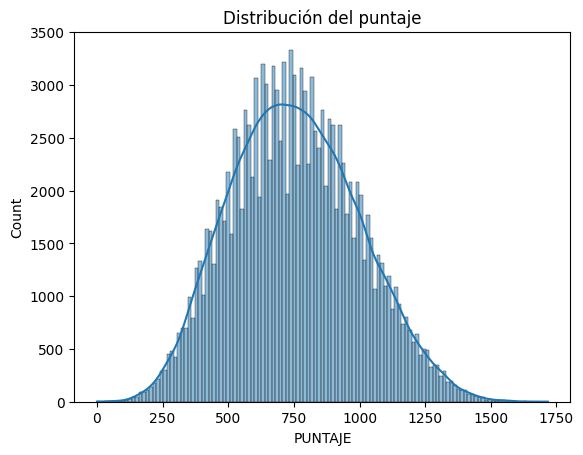

In [ ]:
#solo para variable PUNTAJE que es numérica
sns.histplot(df['PUNTAJE'], kde=True)
plt.title('Distribución del puntaje')
plt.show()

# 3.2. VARIABLES QUE EJERCEN SOBRE EL TARGET


In [ ]:
#se elimina la variable PUESTO al contener valores nulos que no pueden tratarse.
df.drop(['PUESTO'],axis = 1, inplace = True)

#se elimina las variables CODIGO y APELLIDOS Y NOMBRES, por ser irrelevantes.
df.drop(['CODIGO', 'APELLIDOS Y NOMBRES', 'AÑO', 'AÑO_PERIODO', 'MODALIDAD'],axis = 1, inplace = True)
df.head()

,CARRERA,PUNTAJE,ESTATUS,SEDE,PERIODO
0,MEDICINA HUMANA,1007.125,NO INGRESO,LIMA,I
1,MEDICINA HUMANA,480.375,NO INGRESO,LIMA,I
2,MEDICINA HUMANA,504.875,NO INGRESO,LIMA,I
3,MEDICINA HUMANA,733.625,NO INGRESO,LIMA,I
4,MEDICINA HUMANA,733.625,NO INGRESO,LIMA,I


In [ ]:
#se transforma la variable ESTATUS a binaria:
df['TARGET'] = df['ESTATUS'].map({'NO INGRESO': 0, 'INGRESO': 1})
df.drop(columns=['ESTATUS'], inplace=True)

In [ ]:
df.head()

,CARRERA,PUNTAJE,SEDE,PERIODO,TARGET
0,MEDICINA HUMANA,1007.125,LIMA,I,0
1,MEDICINA HUMANA,480.375,LIMA,I,0
2,MEDICINA HUMANA,504.875,LIMA,I,0
3,MEDICINA HUMANA,733.625,LIMA,I,0
4,MEDICINA HUMANA,733.625,LIMA,I,0


In [ ]:
#asignación variables categóricas y numéricas:
target = 'TARGET'
cat_var = ['CARRERA', 'SEDE', 'PERIODO']
num_var = ['PUNTAJE']

VARIABLES CATEGORICAS

In [ ]:
def chi2_test(df, cat_vars, target):
    results = []
    for var in cat_vars:
        tabla = pd.crosstab(df[var], df[target])
        chi2, p, dof, ex = chi2_contingency(tabla)
        results.append({'Variable': var, 'p-value': p})
    return pd.DataFrame(results).sort_values('p-value')

chi2_results = chi2_test(df, cat_var, 'TARGET')
display(chi2_results)

,Variable,p-value
0,CARRERA,0.000000e+00
1,SEDE,0.000000e+00
2,PERIODO,2.396227e-289


<ipython-input-30-96beb816f3e8>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




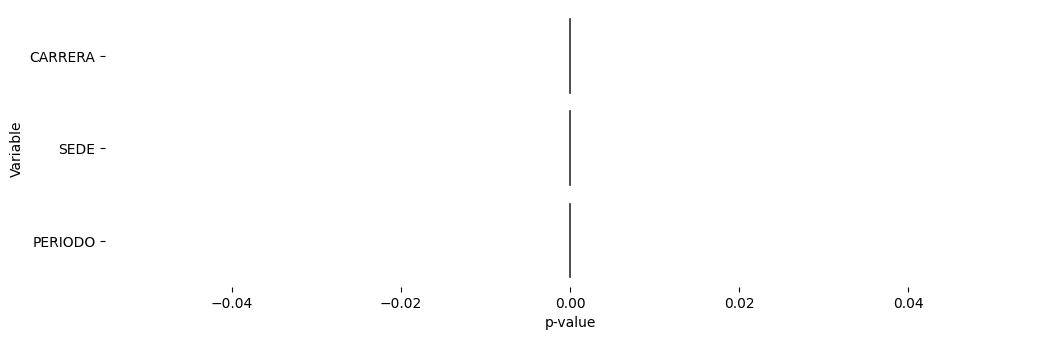

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(chi2_results['Variable'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(chi2_results, x='p-value', y='Variable', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Todos los p-values son mucho menores que 0.05, lo que indica que existe una asociación estadísticamente significativa entre cada una de estas variables y  a probabilidad de ingreso (TARGET)

VARIABLES NUMERICAS (SOLO TARGET)

In [ ]:
def ttest_variables(df, num_vars, target):
    results = []
    grupo_1 = df[df[target] == 1]
    grupo_0 = df[df[target] == 0]
    for var in num_vars:
        t_stat, p_val = ttest_ind(grupo_1[var], grupo_0[var], nan_policy='omit')
        results.append({'Variable': var, 'p-value': p_val})
    return pd.DataFrame(results)

ttest_results = ttest_variables(df, num_var, 'TARGET')
display(ttest_results)

,Variable,p-value
0,PUNTAJE,0.0


Un p-value de 0.0 (o tan bajo que se redondea a cero) significa que existe una diferencia estadísticamente significativa entre los puntajes de quienes ingresaron y los que no.

# **4. MODELLING**

# 4.1. VARIABLE TRANSFORMATION

### 📊 División del dataset

Primero dividimos el dataset considerando lo siguiente:

| Conjunto       | Porcentaje | Uso                                              |
|----------------|------------|--------------------------------------------------|
| **Entrenamiento** | 70%         | Entrenar el modelo                              |
| **Validación**    | 15%         | Ajustar hiperparámetros                         |
| **Prueba (Test)** | 15%         | Evaluar el rendimiento final del modelo         |



In [ ]:
X = df.drop(columns=[target])
y = df[target]

#separación del 15% de prueba (test):
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

#división del 85% restante en entrenamiento (70%) y validación(15%):
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

#confirmamos proporciones
print(f'Train: {len(X_train)} registros')
print(f'Validación: {len(X_val)} registros')
print(f'Test: {len(X_test)} registros')

Train: 96953 registros
Validación: 20780 registros
Test: 20777 registros


Ahora hacemos la transformación de las variables, se realiza después de la partición del dataset porque de lo contrario, estaría permitiendo que información del conjunto de test/validación "se filtre" al entrenamiento. A esto se le llama data leakage.
Si se aplica StandardScaler sobre todo el dataset antes de dividirlo, se estaría calculando la media y desviación estándar usando también los datos de prueba, lo cual contamina la evaluación final.

Lo mismo pasa con OneHotEncoder: si hay una categoría rara que solo aparece en test, y ya se usó para definir las columnas, se estaría dando pistas al modelo desde antes de tiempo.

In [ ]:
#se transforman las variables categóricas con OneHotEncoder y se escalan las numéricas con StandardScaler.
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_var),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_var)
])

StandardScaler: Normaliza las variables numéricas.
OneHotEncoder: Convierte las variables categóricas en variables dummy (0 y 1).

# **4.2. DATA TRAINING**

In [ ]:
#función que evalúa varios modelos de clasificación. para cada modelo se especifica los hiperparámetros a ajustar.

def evaluate_classifiers(X_train, y_train, X_val, y_val, X_test, y_test, preprocessor): #función itera sobre un diccionario de modelos, cada modelo tiene su propio conjunto de hiperparámetros.
    #balanceo de datos
    distribucion_clases = y_train.value_counts() #verifica la distribución de clases
    print("Distribución de Clases en el Conjunto de Entrenamiento:")
    print(distribucion_clases)

    #proporción de clases
    proporción = distribucion_clases.min() / distribucion_clases.max()
    print(f"Proporción de clases: {proporción:.4f}")

    #oversampling si hay desbalance significativo
    if proporción < 0.1:  #si la clase minoritaria es menos del 10% de la mayoritaria
        oversampler = RandomOverSampler(random_state=42)
        X_train, y_train = oversampler.fit_resample(X_train, y_train)
        print("Oversampling aplicado. Nueva distribución de clases:")
        print(y_train.value_counts())
    else:
        print("No se aplicó oversampling, la distribución de clases es aceptable.")

    # Diccionario de modelos con hiperparámetros
    models = {
        'Random Forest': (RandomForestClassifier(), {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None]
        }),
        'Logistic Regression': (LogisticRegression(max_iter=1000), {
            'classifier__C': [0.1, 1, 10]
        }),
        'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 5]
        }),
        'KNN': (KNeighborsClassifier(), {
            'classifier__n_neighbors': [3, 5, 7]
        }),
        'SVM': (SVC(), {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf']
        })
    }

    results = []
    best_models = {}

    #para cada modelo se crea un Pipeline que incluye el preprocesamiento y el clasificador.
    for name, (clf, params) in models.items():
        print(f"\n Entrenando y ajustando hiperparámetros para: {name}")
        pipeline = Pipeline(steps=[
            ('preprocessing', preprocessor),
            ('classifier', clf)
        ])
        #ajuste del modelo
        grid = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy', n_jobs=-1)  #se usa GridSearchCV para ajustar el modelo,encontrar la mejor combinación de hiperparámetros para cada modelo, evaluando su rendimiento mediante validación cruzada.
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_  #se entrena el modelo y se evalúa su precisión en el conjunto de prueba (X_test).
        y_pred_test = best_model.predict(X_test)

        acc = accuracy_score(y_test, y_pred_test)  #una vez encontrado el mejor modelo, se predice el conjunto de prueba y se calcula la precisión (accuracy).
        print(f"✅ {name} - Accuracy en test: {acc:.4f}")

        results.append({    #se guardan los resultados, se almacenan en una lista y convierten en un DataFrame para su visualización.
            'Model': name,
            'Accuracy': acc,
            'Best Params': grid.best_params_
        })

        best_models[name] = best_model #guarda el mejor modelo por nombre

    #resultados como tabla
    df_results = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
    print("\n📊 Resultados Comparativos:")
    print(df_results)

    #modelo con mejor accuracy
    best_model_name = df_results.iloc[0]['Model']
    best_model_overall = best_models[best_model_name]

    #grafico de los accuracy
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Accuracy', y='Model', data=df_results, palette='viridis')
    plt.title('Comparación de Accuracy por Modelo')
    plt.xlabel('Accuracy en Test')
    plt.ylabel('Modelo')
    plt.xlim(0, 1)
    plt.show()

    return best_models, df_results, best_model_name, best_model_overall

Distribución de Clases en el Conjunto de Entrenamiento:
TARGET
0    86247
1    10706
Name: count, dtype: int64
Proporción de clases: 0.1241
No se aplicó oversampling, la distribución de clases es aceptable.

 Entrenando y ajustando hiperparámetros para: Random Forest
✅ Random Forest - Accuracy en test: 0.9459

 Entrenando y ajustando hiperparámetros para: Logistic Regression
✅ Logistic Regression - Accuracy en test: 0.9395

 Entrenando y ajustando hiperparámetros para: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[19:37:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




✅ XGBoost - Accuracy en test: 0.9502

 Entrenando y ajustando hiperparámetros para: KNN
✅ KNN - Accuracy en test: 0.9477

 Entrenando y ajustando hiperparámetros para: SVM
✅ SVM - Accuracy en test: 0.9489

📊 Resultados Comparativos:
                 Model  Accuracy  \
2              XGBoost  0.950185   
4                  SVM  0.948934   
3                  KNN  0.947731   
0        Random Forest  0.945902   
1  Logistic Regression  0.939549   

                                         Best Params  
2  {'classifier__max_depth': 5, 'classifier__n_es...  
4  {'classifier__C': 10, 'classifier__kernel': 'r...  
3                     {'classifier__n_neighbors': 7}  
0  {'classifier__max_depth': None, 'classifier__n...  
1                               {'classifier__C': 1}  


<ipython-input-34-2b2a609027b2>:83: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




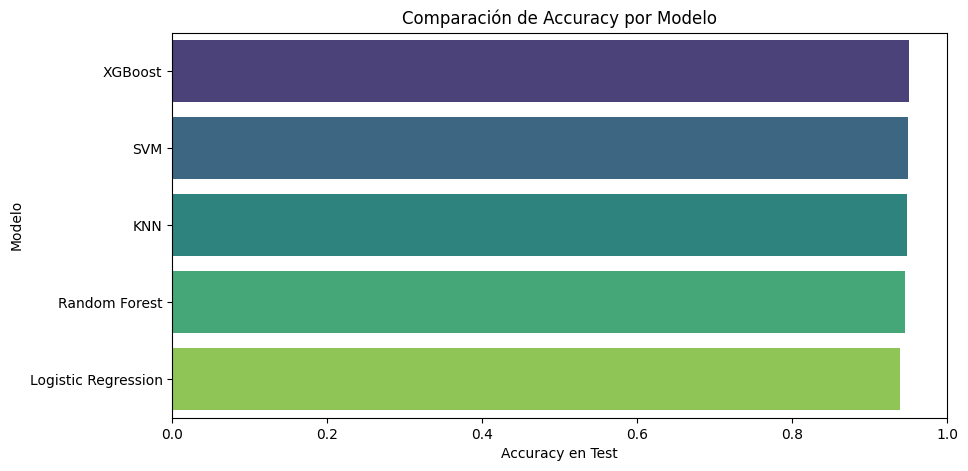

In [ ]:
best_models, df_results, best_model_name, best_model_overall = evaluate_classifiers(X_train, y_train, X_val, y_val, X_test, y_test, preprocessor)

In [ ]:
print(f"Mejor modelo: {best_model_name}")

Mejor modelo: XGBoost


In [ ]:
#se guarda el mejor modelo en un archivo .pkl
joblib.dump(best_model_overall, 'modelo_entrenado.pkl')

['modelo_entrenado.pkl']

In [ ]:
#para cargar el modelo
modelo = joblib.load('modelo_entrenado.pkl')

#4.3. MODEL VALIDATION

🔍 Accuracy en Validación: 0.9508

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     18485
           1       0.86      0.67      0.75      2295

    accuracy                           0.95     20780
   macro avg       0.91      0.83      0.86     20780
weighted avg       0.95      0.95      0.95     20780



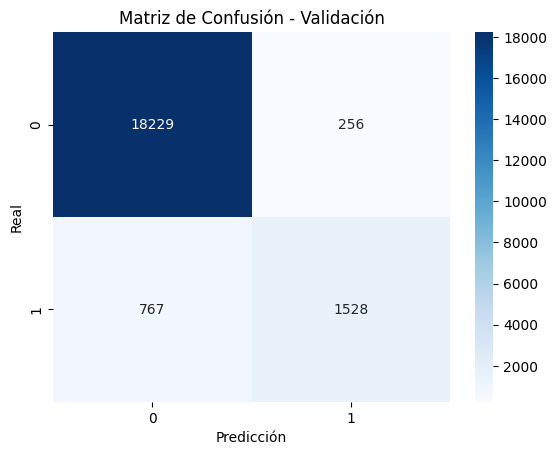

In [ ]:
#para predecir en el conjunto de validación
y_pred_val = modelo.predict(X_val)

#se calcula el accuracy
acc_val = accuracy_score(y_val, y_pred_val)
print(f"🔍 Accuracy en Validación: {acc_val:.4f}")

#se genera un reporte completo
print("\n📋 Classification Report:")
print(classification_report(y_val, y_pred_val))

#matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Validación')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [ ]:
#se simulan nuevos postulantes
new_data = pd.DataFrame([
    {'PUNTAJE': 1200, 'CARRERA': 'INGENIERÍA INDUSTRIAL','SEDE': 'LIMA', 'PERIODO': 'I'},
    {'PUNTAJE': 950,  'CARRERA': 'MEDICINA HUMANA', 'SEDE': 'HUANCAYO', 'PERIODO': 'II'},
    {'PUNTAJE': 1100, 'CARRERA': 'ADMINISTRACIÓN DE EMPRESAS','SEDE': 'LIMA', 'PERIODO': 'II'}
])

#predicción del ingreso
predicciones = modelo.predict(new_data)
print(predicciones)

[0 0 1]
